In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

data = pd.read_csv('alcohol.csv', index_col=0)
data.head()

,abuse,status,unemrate,age,educ,married,famsize,white,exhealth,vghealth,...,mothalc,fathalc,livealc,inwf,employ,agesq,beertaxsq,cigtaxsq,ethanolsq,educsq
1,1,1,4.0,50,4,1,1,1,0,0,...,0,0,0,0,0,2500,0.111556,1444.0,4.159397,16
2,0,3,4.0,37,12,1,5,1,0,0,...,0,0,0,1,1,1369,0.111556,1444.0,4.159397,144
3,0,3,4.0,53,9,1,3,1,1,0,...,0,0,0,1,1,2809,0.111556,1444.0,4.159397,81
4,0,3,3.3,59,11,1,1,1,1,0,...,0,0,0,1,1,3481,0.057600,676.0,6.002402,121
5,0,3,3.3,43,10,1,1,1,1,0,...,0,1,1,1,1,1849,0.057600,676.0,6.002402,100


## EDA

In [2]:
import plotly.graph_objects as go

# Count combinations
counts = data.groupby(['abuse', 'employ']).size().reset_index(name='count')

# Define nodes
labels = ['Abuse=0', 'Abuse=1', 'Employ=0', 'Employ=1']

# Map source and target indices
source = []
target = []
value = []

for _, row in counts.iterrows():
    s = 0 if row['abuse'] == 0 else 1
    t = 2 if row['employ'] == 0 else 3
    source.append(s)
    target.append(t)
    value.append(row['count'])

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels),
    link=dict(source=source, target=target, value=value)
)])

fig.update_layout(title_text="Abuse vs Employment Sankey Plot", font_size=12)
fig.show(renderer='browser')


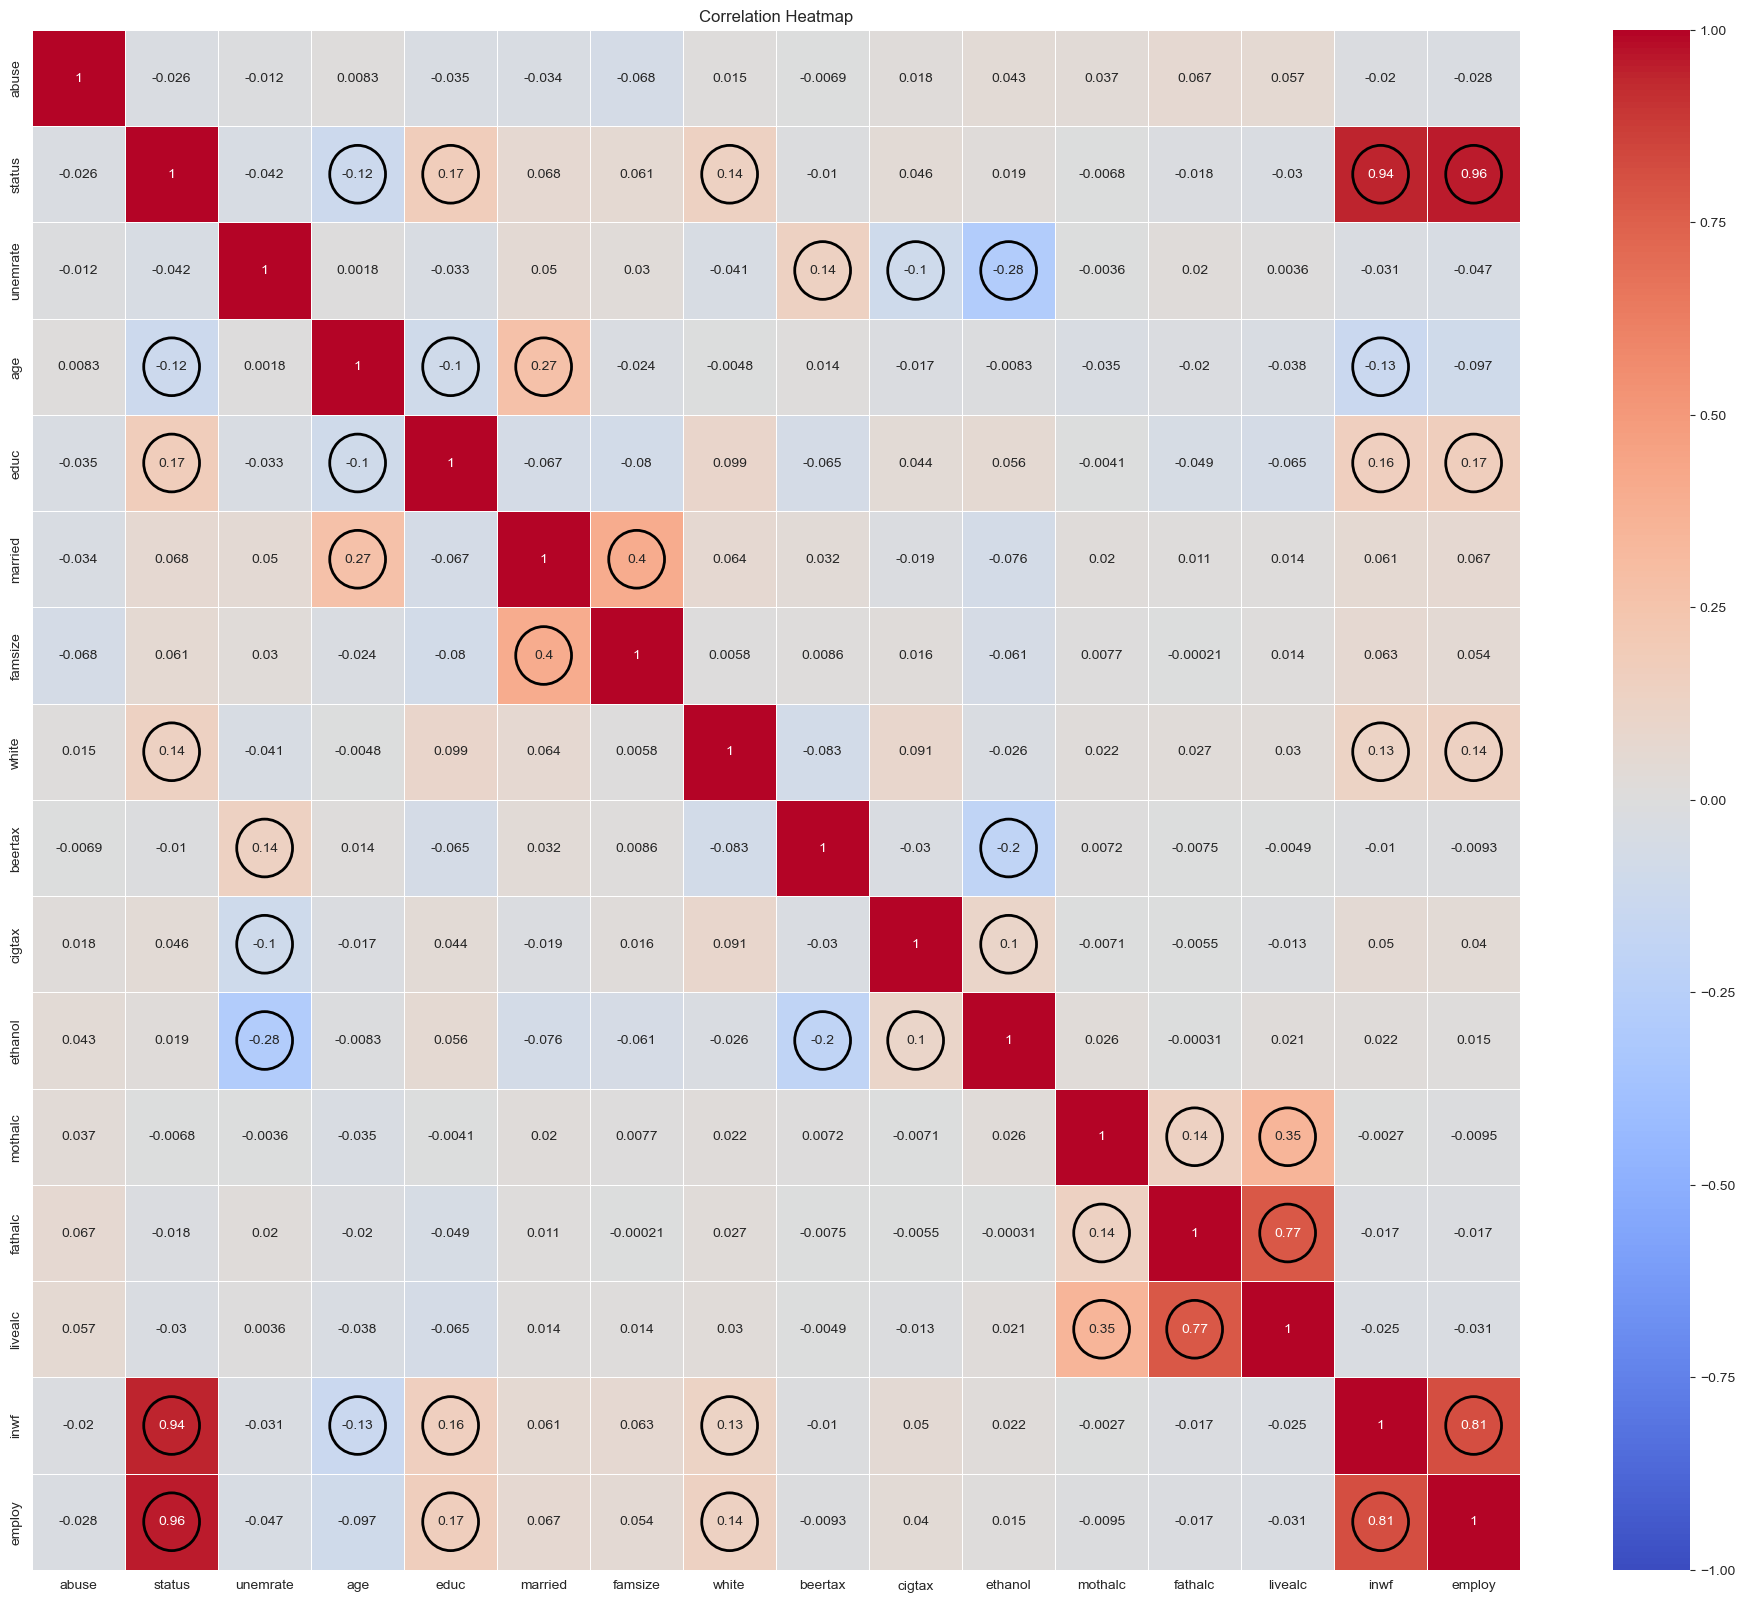

In [3]:
from matplotlib.patches import Circle
# Heatmap
data_heatmap = data.copy()
drop_cols = ['agesq', 'beertaxsq', 'cigtaxsq', 'ethanolsq', 'educsq', 'qrt1', 'qrt2', 'qrt3', 'northeast',
            'midwest', 'south', 'centcity', 'outercity', 'exhealth', 'vghealth', 'goodhealth','fairhealth']
data_heatmap = data_heatmap.drop(drop_cols, axis=1)
corr = data_heatmap.corr()

plt.figure(figsize=(24,20))
ax = sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Loop through the matrix and draw circles for |corr| > 0.5
for i in range(len(corr)):
    for j in range(len(corr)):
        if abs(corr.iloc[i,j]) > 0.1 and i != j:
            ax.add_patch(Circle((j+0.5, i+0.5), 0.3, fill=False, edgecolor='black', lw=2))

plt.title('Correlation Heatmap')
plt.show()

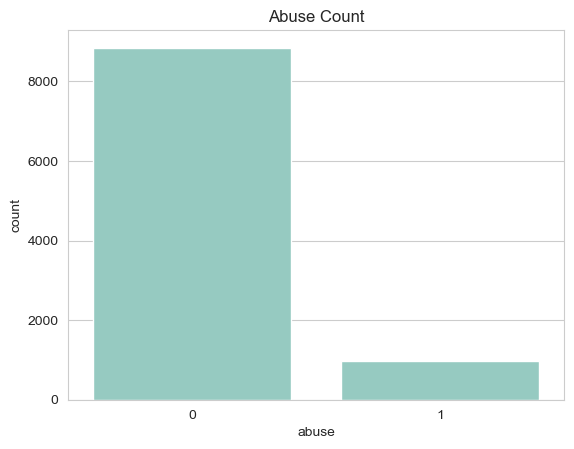

In [4]:
sns.countplot(x='abuse', data=data)
plt.title('Abuse Count')
plt.show()

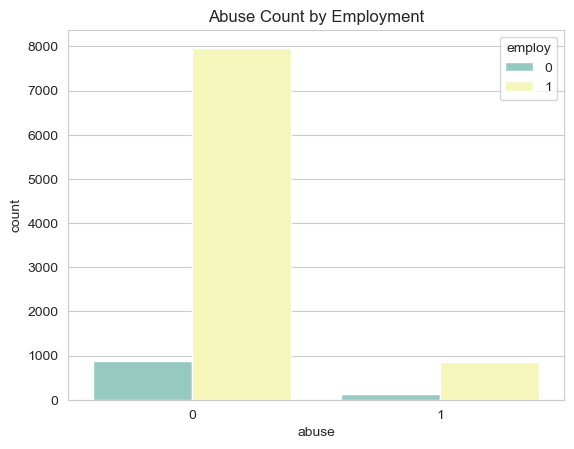

In [5]:
sns.countplot(x='abuse', hue='employ', data=data)
plt.title('Abuse Count by Employment')
plt.show()

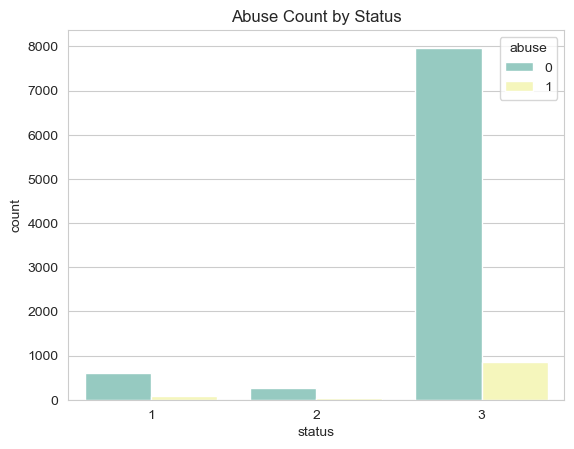

In [6]:
sns.countplot(x='status', hue='abuse', data=data)
plt.title('Abuse Count by Status')
plt.show()

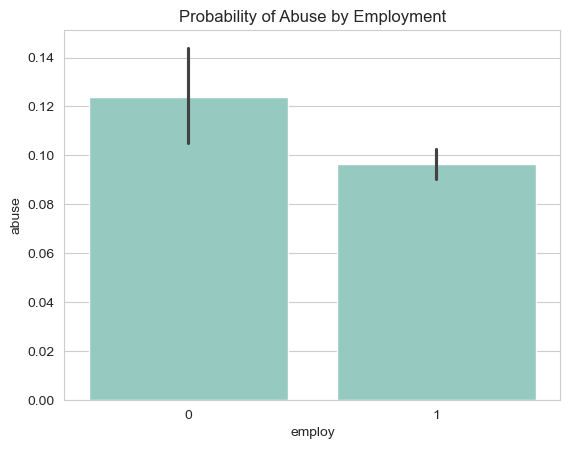

In [7]:
sns.barplot(x='employ', y='abuse', data=data)
plt.title('Probability of Abuse by Employment')
plt.show()

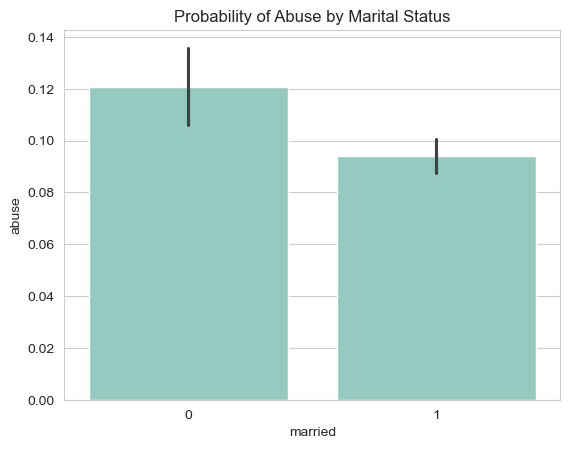

In [8]:
sns.barplot(x='married', y='abuse', data=data)
plt.title('Probability of Abuse by Marital Status')
plt.show()

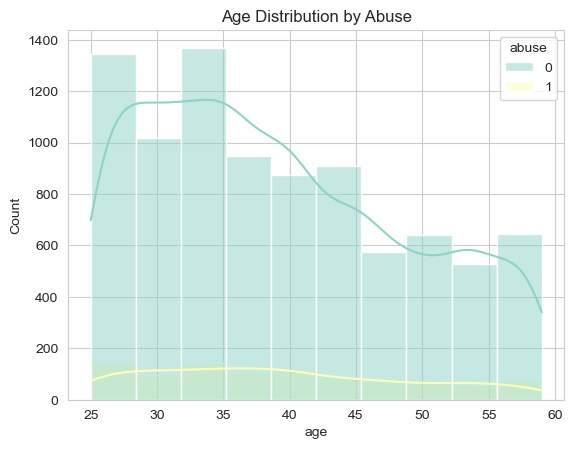

In [9]:
sns.histplot(x='age', hue='abuse', data=data, kde=True, bins=10)
plt.title('Age Distribution by Abuse')
plt.show()

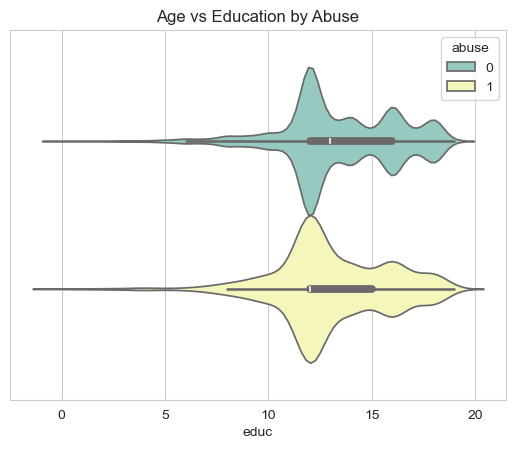

In [10]:
sns.violinplot(x='educ', hue='abuse', data=data)
plt.title('Age vs Education by Abuse')
plt.show()

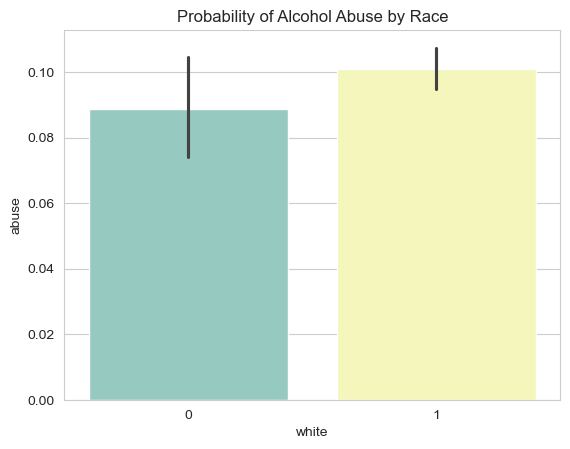

In [11]:
sns.barplot(x='white', y='abuse', data=data, hue='white', legend=False)
plt.title('Probability of Alcohol Abuse by Race')
plt.show()

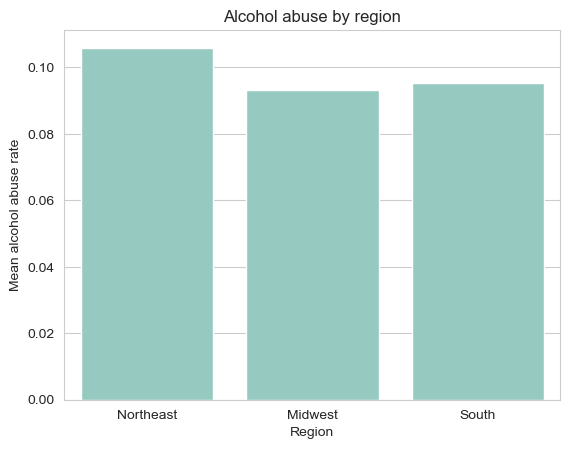

In [12]:
viz = data.copy()
viz['region'] = viz[['northeast', 'midwest', 'south']].idxmax(axis=1)
viz['region'] = viz['region'].replace({
    'northeast': 'Northeast',
    'midwest': 'Midwest',
    'south': 'South'
})

# Compute mean abuse by region
region_abuse = viz.groupby('region')['abuse'].mean().reset_index()

# Plot
sns.barplot(data=region_abuse, x='region', y='abuse', order=['Northeast','Midwest','South'])
plt.ylabel('Mean alcohol abuse rate')
plt.xlabel('Region')
plt.title('Alcohol abuse by region')
plt.show()

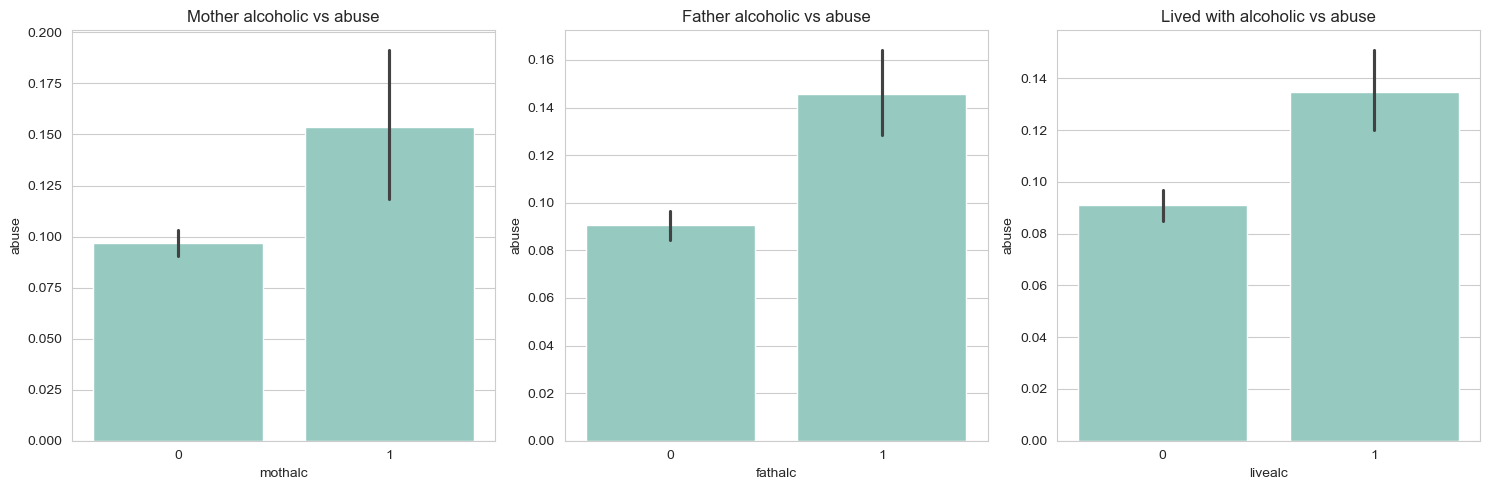

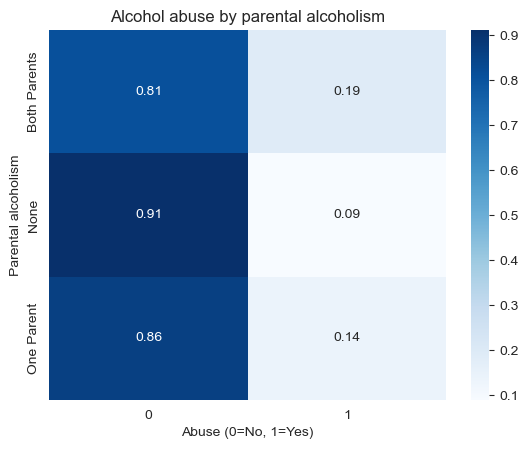

In [13]:
viz = data.copy()

# Barplots: parental alcoholism vs own abuse
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x='mothalc', y='abuse', data=viz, ax=axes[0])
axes[0].set_title('Mother alcoholic vs abuse')
sns.barplot(x='fathalc', y='abuse', data=viz, ax=axes[1])
axes[1].set_title('Father alcoholic vs abuse')
sns.barplot(x='livealc', y='abuse', data=viz, ax=axes[2])
axes[2].set_title('Lived with alcoholic vs abuse')
plt.tight_layout()
plt.show()

# Combined heatmap: parental background vs abuse
viz['parentalc'] = viz[['mothalc', 'fathalc']].sum(axis=1)
viz['parentalc'] = viz['parentalc'].map({0:'None', 1:'One Parent', 2:'Both Parents'})

ct = pd.crosstab(viz['parentalc'], viz['abuse'], normalize='index')
sns.heatmap(ct, annot=True, cmap='Blues', fmt='.2f')
plt.title('Alcohol abuse by parental alcoholism')
plt.ylabel('Parental alcoholism')
plt.xlabel('Abuse (0=No, 1=Yes)')
plt.show()

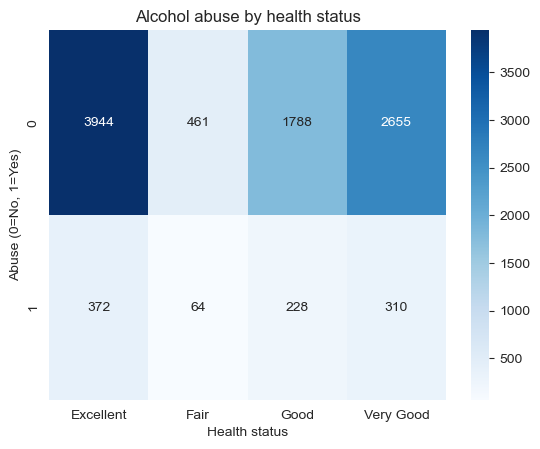

In [14]:
viz = data.copy()
health_vars = ['exhealth', 'vghealth', 'goodhealth', 'fairhealth']

# Create a single categorical health variable
viz['health_status'] = viz[health_vars].idxmax(axis=1)
viz['health_status'] = viz['health_status'].replace({
    'exhealth': 'Excellent',
    'vghealth': 'Very Good',
    'goodhealth': 'Good',
    'fairhealth': 'Fair'
})

# Cross-tabulate
ct = pd.crosstab(viz['abuse'], viz['health_status'])

sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title('Alcohol abuse by health status')
plt.xlabel('Health status')
plt.ylabel('Abuse (0=No, 1=Yes)')
plt.show()

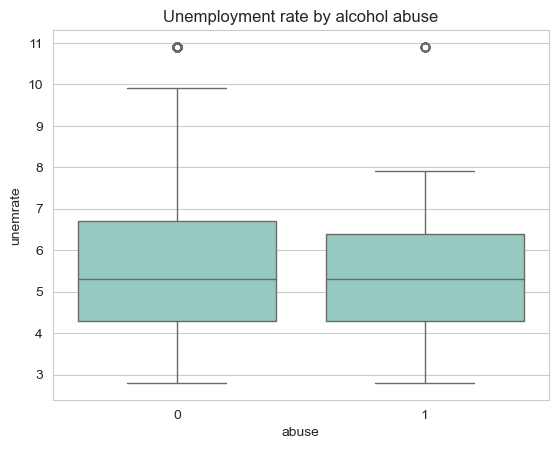

In [15]:
sns.boxplot(x='abuse', y='unemrate', data=data)
plt.title('Unemployment rate by alcohol abuse')
plt.show()

## Modelling

(i) What fraction of the sample is employed at the time of the interview? What fraction of the sample has abused alcohol?

In [16]:
employed_frac = data['employ'].mean()
abuse_frac = data['abuse'].mean()
employed_frac, abuse_frac

(np.float64(0.8981877418041132), np.float64(0.09916513948279373))

(ii) Run the simple regression of employ on abuse and report the results in the usual form, obtaining the heteroskedasticity-robust standard errors. Interpret the estimated equation. Is the relationship as you expected? Is it statistically significant?

In [17]:
import statsmodels.api as sm
X = sm.add_constant(data['abuse'])
y = data['employ']
model = sm.OLS(y, X).fit(cov_type='HC1')  # robust SE
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 employ   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.452
Date:                Sat, 25 Oct 2025   Prob (F-statistic):             0.0111
Time:                        16:23:46   Log-Likelihood:                -2185.9
No. Observations:                9822   AIC:                             4376.
Df Residuals:                    9820   BIC:                             4390.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9010      0.003    283.733      0.0

(iii) Run a probit of employ on abuse. Do you get the same sign and statistical significance as in part (i1)? How does the average partial effect for the probit compare with that for the linear probability model?

In [18]:
probit_model = sm.Probit(y, X).fit()
print(probit_model.summary(), '\n\n')

mfx = probit_model.get_margeff(method='dydx', at='overall')  # 'overall' = APE
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.328678
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                 employ   No. Observations:                 9822
Model:                         Probit   Df Residuals:                     9820
Method:                           MLE   Df Model:                            1
Date:                Sat, 25 Oct 2025   Pseudo R-squ.:                0.001120
Time:                        16:23:46   Log-Likelihood:                -3228.3
converged:                       True   LL-Null:                       -3231.9
Covariance Type:            nonrobust   LLR p-value:                  0.007140
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2872      0.018     70.630      0.000       1.252       1.323
abuse         -0.1480      0.

(iv) Obtain the fitted values for the LPM estimated in part ii) and report what they are when abuse = 0 and when abuse = 1. How do these compare to the probit fitted values, and why?

In [19]:
fitted_lpm_0 = model.predict([1, 0])[0]
fitted_lpm_1 = model.predict([1, 1])[0]
fitted_probit_0 = probit_model.predict([1, 0])[0]
fitted_probit_1 = probit_model.predict([1, 1])[0]

print(fitted_lpm_0, fitted_lpm_1)
print(fitted_probit_0, fitted_probit_1)

0.900994575045222 0.8726899383983704
0.900994575045208 0.8726899383983573


(v) To the LPM in part (i) add the variables age, agesq, educ, educsq, married, famsize, white, northeast, midwest, south, centcity, outercity, qrtl, qrt2, and qrt3. What happens to the coefficient on abuse and its statistical significance?

In [20]:
controls = ['age','agesq','educ','educsq','married','famsize','white']
X2 = sm.add_constant(data[['abuse'] + controls])
model2 = sm.OLS(y, X2).fit(cov_type='HC1')
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 employ   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     55.48
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           8.74e-89
Time:                        16:23:47   Log-Likelihood:                -1851.8
No. Observations:                9822   AIC:                             3722.
Df Residuals:                    9813   BIC:                             3786.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1703      0.078      2.180      0.0

(vi) Estimate a probit model using the variables in part (v). Find the APE of abuse and its t statistic. Is the estimated effect now identical to that for the linear model? Is it "close"?

In [21]:
probit2 = sm.Probit(y, X2).fit()
# Compute APE for abuse
pred_prob2 = probit2.predict(X2)
print(probit2.summary(), '\n\n')

mfx2 = probit2.get_margeff(method='dydx', at='overall')  # 'overall' = APE
print(mfx2.summary())

Optimization terminated successfully.
         Current function value: 0.299888
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                 employ   No. Observations:                 9822
Model:                         Probit   Df Residuals:                     9813
Method:                           MLE   Df Model:                            8
Date:                Sat, 25 Oct 2025   Pseudo R-squ.:                 0.08862
Time:                        16:23:58   Log-Likelihood:                -2945.5
converged:                       True   LL-Null:                       -3231.9
Covariance Type:            nonrobust   LLR p-value:                1.640e-118
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7695      0.370     -4.789      0.000      -2.494      -1.045
abuse         -0.1221      0.

(vii) Variables indicating the overall health of each man are also included in the data set. Is it obvious that such variables should be included as controls? Explain.


(viii) Why might abuse be properly thought of as endogenous in the employ equation? Do you think the variables mothale and fathalc, indicating whether a man's mother or father were alcoholics, are sensible instrumental variables for abuse?

(ix) Estimate the LPM underlying part (v) by 2SLS, where mothale and fathalc act as IVs for abuse. Is the difference between the 2SLS and OLS coefficients practically large? 

In [22]:
from linearmodels.iv import IV2SLS
iv_model = IV2SLS(y, X2[['const'] + controls], data['abuse'], data[['mothalc','fathalc', 'livealc', 'beertax', 'beertaxsq']]).fit(cov_type='robust')
print(iv_model)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 employ   R-squared:                     -0.0526
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0535
No. Observations:                9822   F-statistic:                    413.82
Date:                Sat, Oct 25 2025   P-value (F-stat)                0.0000
Time:                        16:24:35   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.1694     0.0808     2.0971     0.0360      0.0111      0.3277
age            0.0180     0.0034     5.2993     0.00

(x) Use the test described in Section 15.5 to test whether abuse is endogenous in the LPM.

In [23]:
# Instruments and controls
instruments = ['mothalc', 'fathalc', 'beertax', 'beertaxsq', 'livealc']

X_first = sm.add_constant(data[instruments + controls])
y_first = data['abuse']
first_stage = sm.OLS(y_first, X_first).fit()
data['resid_abuse'] = first_stage.resid

X_second = sm.add_constant(data[['abuse'] + controls + ['resid_abuse']])
y_second = data['employ']
second_stage = sm.OLS(y_second, X_second).fit(cov_type='HC1')
print(second_stage.summary())

                            OLS Regression Results                            
Dep. Variable:                 employ   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     49.62
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           1.86e-88
Time:                        16:24:53   Log-Likelihood:                -1848.8
No. Observations:                9822   AIC:                             3718.
Df Residuals:                    9812   BIC:                             3789.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1694      0.078      2.172      

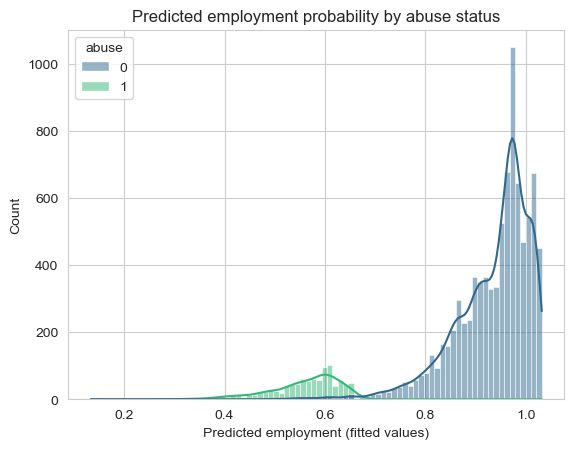

In [24]:
viz = data.copy()
viz['pred_employ'] = iv_model.fitted_values
sns.histplot(data=viz, x='pred_employ', hue='abuse', kde=True, palette='viridis')
plt.title('Predicted employment probability by abuse status')
plt.xlabel('Predicted employment (fitted values)')
plt.ylabel('Count')
plt.show()

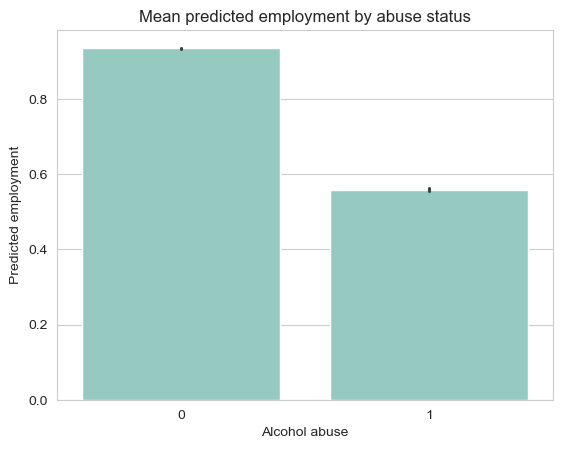

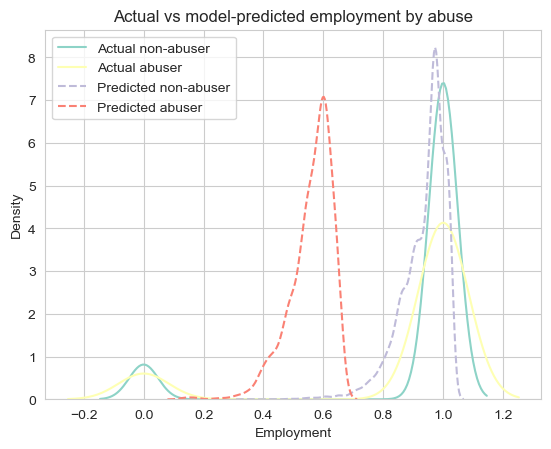

In [ ]:
# Mean predicted employment by abuse group
sns.barplot(x='abuse', y='pred_employ', data=viz)
plt.title('Mean predicted employment by abuse status')
plt.xlabel('Alcohol abuse')
plt.ylabel('Predicted employment')
plt.show()

# Difference plot: actual vs predicted
sns.kdeplot(viz.loc[viz['abuse']==0, 'employ'], label='Actual non-abuser') # type: ignore
sns.kdeplot(viz.loc[viz['abuse']==1, 'employ'], label='Actual abuser') # type: ignore
sns.kdeplot(viz.loc[viz['abuse']==0, 'pred_employ'], linestyle='--', label='Predicted non-abuser') # type: ignore
sns.kdeplot(viz.loc[viz['abuse']==1, 'pred_employ'], linestyle='--', label='Predicted abuser') # type: ignore
plt.title('Actual vs model-predicted employment by abuse')
plt.xlabel('Employment')
plt.legend()
plt.show()


In [26]:
print(iv_model.first_stage.summary)

     First Stage Estimation Results    
                                  abuse
---------------------------------------
R-squared                        0.0126
Partial R-squared                0.0048
Shea's R-squared                 0.0048
Partial F-statistic              34.898
P-value (Partial F-stat)      1.576e-06
Partial F-stat Distn            chi2(5)
========================== ============
const                            0.0109
                               (0.1624)
age                              0.0047
                               (1.5842)
agesq                        -5.253e-05
                              (-1.4523)
educ                             0.0081
                               (1.4836)
educsq                          -0.0005
                              (-2.3386)
married                         -0.0145
                              (-1.5498)
famsize                         -0.0131
                              (-5.7352)
white                            0.0143
